<a href="https://colab.research.google.com/github/PTHC4231/Datathon-2023/blob/main/Auto_ECG_Diagnose_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

In [ ]:
!pip install pydicom
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings; warnings.filterwarnings('ignore')
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/PTB-XL Cleaned data/train_meta.csv',index_col=0)
train_signal = pd.read_csv('/content/drive/MyDrive/PTB-XL Cleaned data/train_signal.csv')

valid_df = pd.read_csv('/content/drive/MyDrive/PTB-XL Cleaned data/valid_meta.csv',index_col=0)
valid_signal = pd.read_csv('/content/drive/MyDrive/PTB-XL Cleaned data/valid_signal.csv')

test_df = pd.read_csv('/content/drive/MyDrive/PTB-XL Cleaned data/test_meta.csv',index_col=0)
test_signal = pd.read_csv('/content/drive/MyDrive/PTB-XL Cleaned data/test_signal.csv')

In [ ]:
print(train_df.shape)

(17418, 36)


In [ ]:
train_df

,age,sex,height,weight,nurse,site,device,NORM,MI,STTC,...,sub_SEHYP,sub_ISCI,sub_ISC_,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_PMI,sub_WPW,strat_fold
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
2,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,5
4,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
5,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,0,...,0,0,0,0,0,0,0,0,0,7
21833,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,1,...,0,0,0,0,0,0,0,0,0,7
21834,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,0,...,0,0,0,0,0,0,0,0,0,4


In [ ]:
train_signal.shape

(17418000, 13)

In [ ]:
train_signal.head(5)

,ecg_id,channel-0,channel-1,channel-2,channel-3,channel-4,channel-5,channel-6,channel-7,channel-8,channel-9,channel-10,channel-11
0,1,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,1,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,1,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,1,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058


In [ ]:
class PTBXLDatasetPreprocesser():
    def __init__(self):
        pass

    def save(self, filename):
        data = {
            'superclass_cols': self.superclass_cols,
            'subclass_cols': self.subclass_cols,
            'meta_num_cols': self.meta_num_cols,
            'meta_num_means': self.meta_num_means,
            'min_max_scaler': self.min_max_scaler,
            'meta_cat_cols': self.meta_cat_cols,
            'cat_lablers': self.cat_lablers,
        }
        pd.to_pickle(data, filename)

    def load(self, filename):
        data = pd.read_pickle(filename)
        self.min_max_scaler = data['min_max_scaler']
        self.cat_lablers = data['cat_lablers']

    def fit(self, x, y):
        x = x.copy()
        y = y.copy()

        self.superclass_cols = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

        self.subclass_cols = [col for col in y.columns if 'sub_' in col]

        self.meta_num_cols = ['age', 'height', 'weight']
        self.meta_num_means = []
        for col in self.meta_num_cols:
            print(col, y[col].mean())
            y[col] = y[col].fillna(y[col].mean())
            self.meta_num_means += [y[col].mean()]

            self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])

        self.meta_cat_cols = ['sex'] #, 'nurse', 'device']
        self.cat_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_cat_cols]
        return self

    def transform(self, x, y):

        channel_cols = x.columns.tolist()[1:]

        ret = []
        x = x[channel_cols].values.reshape(-1, 1000, 12)
        print(x.shape)
        ret += [x] # signal

        y_ = y.copy()

        for i, col in enumerate(self.meta_num_cols):
            y_[col] = y_[col].fillna(self.meta_num_means[i])
        y_[self.meta_num_cols] = self.min_max_scaler.transform(y_[self.meta_num_cols])
        y_[self.meta_num_cols] = np.clip(y_[self.meta_num_cols], 0., 1.) # prevent extreme value far from train set

        ret += [y_[self.meta_num_cols]] # meta num features

        for i, col in enumerate(self.meta_cat_cols):
            y_[col] = y_[col].fillna('none').astype(str)
            y_[col] = self.cat_lablers[i].transform(y_[col])

        ret += [y_[self.meta_cat_cols]] # meta cat features

        if np.isin(self.superclass_cols, y.columns).sum() == len(self.superclass_cols):
            ret += [y[self.superclass_cols].fillna(0).astype(int)] # superclass targets

            if np.isin(self.subclass_cols, y.columns).sum() == len(self.subclass_cols):
                ret += [y[self.subclass_cols].fillna(0).astype(int)] # subclass targets

        return ret

In [ ]:
data_preprocessor = PTBXLDatasetPreprocesser()
data_preprocessor.fit(train_signal, train_df)
train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass = data_preprocessor.transform(train_signal, train_df)
valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass = data_preprocessor.transform(valid_signal, valid_df)
test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass = data_preprocessor.transform(test_signal, test_df)

print(train_signal.shape)
print(valid_meta_num_feats.isna().sum(), valid_meta_cat_feats.isna().sum(), valid_superclass.isna().sum(), valid_subclass.isna().sum())

display(train_meta_num_feats)
display(train_meta_cat_feats)
display(train_superclass)
display(train_subclass)

age 62.34958089332874
height 166.68729758906082
weight 70.69448666574547
(17418, 1000, 12)
(2183, 1000, 12)
(2198, 1000, 12)
(17418, 1000, 12)
age       0
height    0
weight    0
dtype: int64 sex    0
dtype: int64 NORM    0
MI      0
STTC    0
CD      0
HYP     0
dtype: int64 sub_NORM         0
sub_IMI          0
sub_STTC         0
sub_NST_         0
sub_LVH          0
sub_LAFB/LPFB    0
sub_IRBBB        0
sub_RVH          0
sub_RAO/RAE      0
sub_IVCD         0
sub_LMI          0
sub_AMI          0
sub_ISCA         0
sub__AVB         0
sub_SEHYP        0
sub_ISCI         0
sub_ISC_         0
sub_CRBBB        0
sub_CLBBB        0
sub_LAO/LAE      0
sub_ILBBB        0
sub_PMI          0
sub_WPW          0
dtype: int64


,age,height,weight
ecg_id,,,
1,0.181208,0.791563,0.282927
2,0.057047,0.791563,0.317073
3,0.117450,0.791563,0.312195
4,0.073826,0.791563,0.375610
5,0.057047,0.791563,0.317073
...,...,...,...
21832,0.204698,0.791563,0.320461
21833,0.218121,0.791563,0.320461
21834,1.000000,0.791563,0.320461


,sex
ecg_id,
1,1
2,0
3,1
4,0
5,1
...,...
21832,0
21833,1
21834,0


,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21832,0,0,0,1,0
21833,0,0,1,0,0
21834,1,0,0,0,0


,sub_NORM,sub_IMI,sub_STTC,sub_NST_,sub_LVH,sub_LAFB/LPFB,sub_IRBBB,sub_RVH,sub_RAO/RAE,sub_IVCD,...,sub__AVB,sub_SEHYP,sub_ISCI,sub_ISC_,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_PMI,sub_WPW
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
21833,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21834,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_signal[0, 0, :]

array([-0.119, -0.055,  0.064,  0.086, -0.091,  0.004, -0.069, -0.031,
        0.   , -0.026, -0.039, -0.079])

In [ ]:
data_preprocessor.save('data_preprocessor.pkl')

In [ ]:
#TRAINING A PYTORCH RNN MODEL

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

class ECGDataset(Dataset):
    def __init__(self, signals, num_metas, cat_metas, superclass_labels=None, subclass_labels=None):
        self.signals = signals
        self.num_metas = num_metas
        self.cat_metas = cat_metas
        self.superclass_labels = superclass_labels
        self.subclass_labels = subclass_labels

    def __len__(self):
        return self.signals.shape[0]

    def __getitem__(self, idx):

        ret = []
        ret += [self.signals[idx,:]]
        ret += [self.num_metas.values[idx,:]]
        ret += [self.cat_metas.values[idx,:]]

        if self.superclass_labels is not None:
            ret += [self.superclass_labels.values[idx,:]]

        if self.subclass_labels is not None:
            ret += [self.subclass_labels.values[idx,:]]

        return ret

In [ ]:
class ECGClassifier(nn.Module):
    def __init__(self, signal_channel_size, gru_hidden_size, per_cat_nunique, embed_size, num_size, hidden, n_outs):
        super().__init__()

        self.gru1 = nn.GRU(signal_channel_size, gru_hidden_size, batch_first=True, bidirectional=True)
        #self.lstm2 = nn.LSTM(gru_hidden_size*2, gru_hidden_size, batch_first=True, bidirectional=True)

        self.embeds = []
        self.per_cat_nunique = per_cat_nunique
        for v in self.per_cat_nunique:
            self.embeds += [nn.Embedding(v, embed_size)]
        self.embeds = nn.ModuleList(self.embeds)

        self.dense1 = nn.Linear(gru_hidden_size*4 + embed_size*len(per_cat_nunique) + num_size, hidden)
        self.relu = nn.ReLU()
        self.out = nn.Linear(hidden, n_outs)

    def forward(self, signal, num_meta, cat_meta):
        #print(signal.shape)
        signal = signal.view(signal.shape[0], signal.shape[1], -1)
        #print(signal.shape)
        signal, _ = self.gru1(signal)
        #signal, _ = self.lstm2(signal)

        avg_pool = torch.mean(signal, 1)
        max_pool, _ = torch.max(signal, 1)

        cat_feats = []
        for i, embed in enumerate(self.embeds):
            cat_feats += [embed(cat_meta[:,i].long())]
        cat_feats = torch.cat(cat_feats, 1)

        x = torch.cat([avg_pool, max_pool, cat_feats, num_meta], 1)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.out(x)

        return x

In [ ]:
def prepare_dataloader(signal, meta_num_feats, meta_cat_feats, superclass, subclass):

    ds = ECGDataset(signal, meta_num_feats, meta_cat_feats, superclass_labels=superclass, subclass_labels=subclass)

    dl = torch.utils.data.DataLoader(
        ds,
        batch_size=128,
        pin_memory=False,
        drop_last=False,
        shuffle=True,
        num_workers=4,
        #sampler=BalanceClassSampler(labels=y_train, mode='downsampling'),
    )
    return dl

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (signal, num_meta, cat_meta, superclass_labels, subclass_labels) in pbar:
        signal = signal.to(device).float()
        num_meta = num_meta.to(device).float()
        cat_meta = cat_meta.to(device).long()

        superclass_labels = superclass_labels.to(device).long()
        subclass_labels = subclass_labels.to(device).long()
        labels = torch.cat([superclass_labels, subclass_labels], 1).float()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            preds = model(signal, num_meta, cat_meta)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            #print(preds, labels)
            loss = loss_fn(preds, labels)
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is not None and schd_batch_update:
            scheduler.step()

        description = f'epoch {epoch} loss: {running_loss:.4f}'

        pbar.set_description(description)

    if scheduler is not None and not schd_batch_update:
        scheduler.step()

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    preds_all = []
    targets_all = []

    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (signal, num_meta, cat_meta, superclass_labels, subclass_labels) in pbar:
        signal = signal.to(device).float()
        num_meta = num_meta.to(device).float()
        cat_meta = cat_meta.to(device).long()

        superclass_labels = superclass_labels.to(device)
        subclass_labels = subclass_labels.to(device)
        labels = torch.cat([superclass_labels, subclass_labels], 1).float()

        preds = model(signal, num_meta, cat_meta)   #output = model(input)

        preds_all += [preds.detach().cpu().numpy()]
        targets_all += [labels.detach().cpu().numpy()]

        loss = loss_fn(preds, labels)

        loss_sum += loss.item()*labels.shape[0]
        sample_num += labels.shape[0]

        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)

    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)
    superclass_cnt = superclass_labels.shape[1]
    print('validation superclass multi-label acc = {:.4f}'.format((targets_all[:,:superclass_cnt]==(preds_all[:,:superclass_cnt] >= 0.5)).mean()))
    print('validation superclass multi-label auc = {:.4f}'.format(roc_auc_score(targets_all[:,:superclass_cnt], preds_all[:,:superclass_cnt], average='macro')))
    print('validation multi-label acc = {:.4f}'.format((targets_all==(preds_all >= 0.5)).mean()))
    print('validation multi-label auc = {:.4f}'.format(roc_auc_score(targets_all, preds_all, average='macro')))

    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

    return targets_all, preds_all

In [ ]:
if __name__ == '__main__':


    seed = 719
    epochs = 6
    stepsize= 2
    hidden_size = 64
    seed_everything(719)


    train_loader = prepare_dataloader(train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass)
    val_loader = prepare_dataloader(valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass)

    #test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass = data_preprocessor.transform(test_signal, test_df)

    device = torch.device('cuda:0')

    per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]
    model = ECGClassifier(train_signal.shape[2], 128, per_cat_nunique, 30, train_meta_num_feats.shape[1], 128,
                          train_superclass.shape[1]+train_subclass.shape[1]).to(device)
    scaler = GradScaler()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=stepsize)

    loss_tr = nn.BCEWithLogitsLoss().to(device)
    loss_fn = nn.BCEWithLogitsLoss().to(device)

    for epoch in range(epochs):
        train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

        with torch.no_grad():
            val_targets, val_preds = valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

    torch.save(model.state_dict(),'pytorch_ecg_rnn.pth')

    #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
    del optimizer, train_loader, val_loader, scaler, scheduler
    torch.cuda.empty_cache()

epoch 0 loss: 0.1735: 100%|██████████| 18/18 [00:00<00:00, 25.73it/s]


validation superclass multi-label acc = 0.8290
validation superclass multi-label auc = 0.8838
validation multi-label acc = 0.9302
validation multi-label auc = 0.8451


epoch 1 loss: 0.1477: 100%|██████████| 18/18 [00:00<00:00, 19.98it/s]


validation superclass multi-label acc = 0.8648
validation superclass multi-label auc = 0.9047
validation multi-label acc = 0.9425
validation multi-label auc = 0.8740


epoch 2 loss: 0.1398: 100%|██████████| 18/18 [00:00<00:00, 27.41it/s]


validation superclass multi-label acc = 0.8731
validation superclass multi-label auc = 0.9125
validation multi-label acc = 0.9457
validation multi-label auc = 0.8756


epoch 3 loss: 0.1401: 100%|██████████| 18/18 [00:00<00:00, 19.78it/s]


validation superclass multi-label acc = 0.8722
validation superclass multi-label auc = 0.9134
validation multi-label acc = 0.9457
validation multi-label auc = 0.8762


epoch 4 loss: 0.1361: 100%|██████████| 18/18 [00:00<00:00, 27.00it/s]


validation superclass multi-label acc = 0.8750
validation superclass multi-label auc = 0.9155
validation multi-label acc = 0.9467
validation multi-label auc = 0.8784


epoch 5 loss: 0.1361: 100%|██████████| 18/18 [00:00<00:00, 20.32it/s]


validation superclass multi-label acc = 0.8770
validation superclass multi-label auc = 0.9158
validation multi-label acc = 0.9471
validation multi-label auc = 0.8787


In [ ]:
valid_meta_num_feats.isna().sum()

age       0
height    0
weight    0
dtype: int64

In [ ]:
def predict(data_preprocessor, test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass):
    tst_loader = prepare_dataloader(test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass)

    device = torch.device('cpu')
    per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]
    model = ECGClassifier(train_signal.shape[2], 128, per_cat_nunique, 30, train_meta_num_feats.shape[1], 128,
                          train_superclass.shape[1]+train_subclass.shape[1]).to(device)
    model.load_state_dict(torch.load('pytorch_ecg_rnn.pth', map_location='cpu'))

    preds_all = []
    targets_all = []
    pbar = tqdm(enumerate(tst_loader), total=len(tst_loader))
    for step, (signal, num_meta, cat_meta, superclass_labels, subclass_labels) in pbar:
        signal = signal.to(device).float()
        num_meta = num_meta.to(device).float()
        cat_meta = cat_meta.to(device).long()

        superclass_labels = superclass_labels.to(device)
        subclass_labels = subclass_labels.to(device)
        labels = torch.cat([superclass_labels, subclass_labels], 1).float()

        preds = model(signal, num_meta, cat_meta)   #output = model(input)

        preds_all += [preds.detach().cpu().numpy()]
        targets_all += [labels.detach().cpu().numpy()]


    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)
    superclass_cnt = superclass_labels.shape[1]
    print('test superclass multi-label acc = {:.4f}'.format((targets_all[:,:superclass_cnt]==(preds_all[:,:superclass_cnt] >= 0.5)).mean()))
    print('test superclass multi-label auc = {:.4f}'.format(roc_auc_score(targets_all[:,:superclass_cnt], preds_all[:,:superclass_cnt], average='macro')))
    print('test multi-label acc = {:.4f}'.format((targets_all==(preds_all >= 0.5)).mean()))
    print('test multi-label auc = {:.4f}'.format(roc_auc_score(targets_all, preds_all, average='macro')))

    return preds_all, targets_all

test_prob_preds, test_labels = predict(data_preprocessor, test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass)
test_pred = (test_prob_preds>=0.5).astype(int)

100%|██████████| 18/18 [00:31<00:00,  1.75s/it]

test superclass multi-label acc = 0.8717
test superclass multi-label auc = 0.9091
test multi-label acc = 0.9464
test multi-label auc = 0.8816


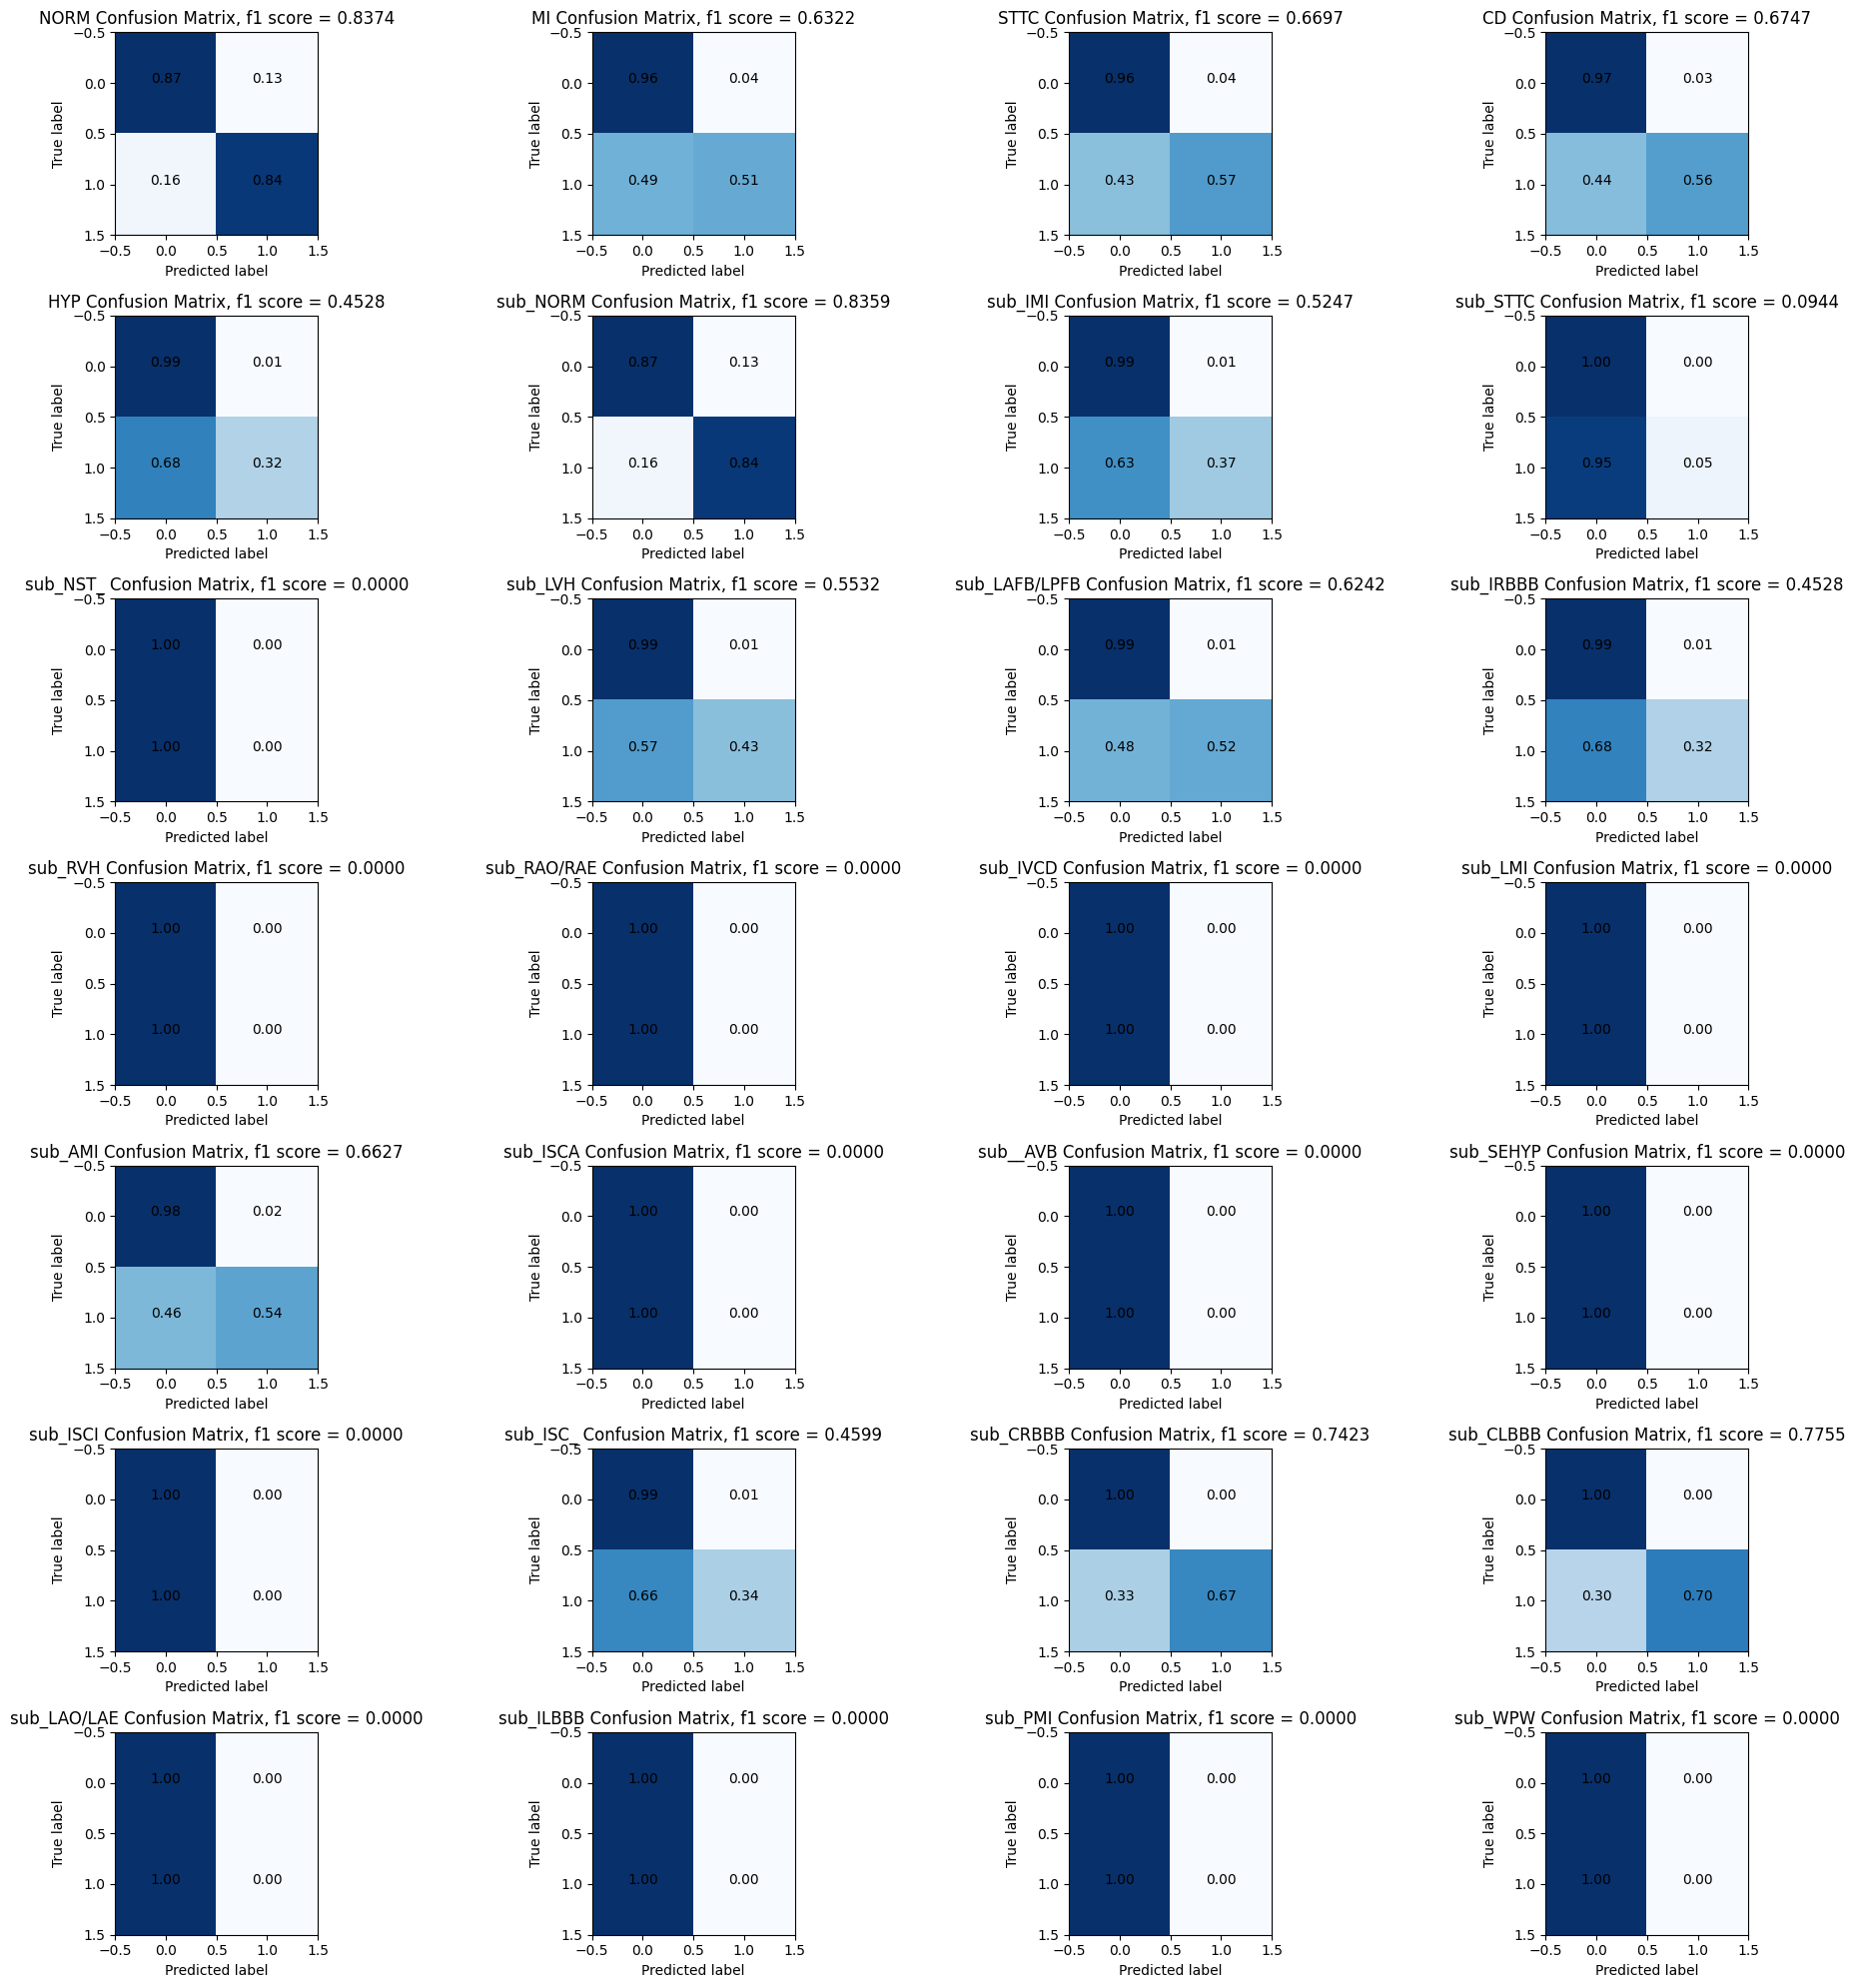

In [ ]:
cols = list(data_preprocessor.superclass_cols) + list(data_preprocessor.subclass_cols)
fig, axes = plt.subplots(int(np.ceil(len(cols)/4)), 4, figsize=(20, 20))

for i, col in enumerate(cols):

    ax = axes[int(np.floor(i/4)), i%4]
    cm = confusion_matrix(test_labels[:, i], test_pred[:, i])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fls = f1_score(test_labels[:, i], test_pred[:, i])

    ax.set_title('{} Confusion Matrix, f1 score = {:.4f}'.format(col, fls))

    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")


    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

plt.tight_layout()
plt.show()

In [ ]:
# Export to ONYX
tst_loader = prepare_dataloader(test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass)

device = torch.device('cpu')
per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]
model = ECGClassifier(train_signal.shape[2], 128, per_cat_nunique, 30, train_meta_num_feats.shape[1], 128,
                      train_superclass.shape[1]+train_subclass.shape[1]).to(device)
model.load_state_dict(torch.load('pytorch_ecg_rnn.pth', map_location='cpu'))

preds_all = []
targets_all = []
for step, (signal, num_meta, cat_meta, superclass_labels, subclass_labels) in enumerate(tst_loader):
    signal = signal.to(device).float()
    num_meta = num_meta.to(device).float()
    cat_meta = cat_meta.to(device).long()

    superclass_labels = superclass_labels.to(device)
    subclass_labels = subclass_labels.to(device)
    labels = torch.cat([superclass_labels, subclass_labels], 1).float()

    preds = model(signal, num_meta, cat_meta)   #output = model(input)

    preds_all += [preds.detach().cpu().numpy()]
    targets_all += [labels.detach().cpu().numpy()]
    break

In [ ]:
!pip install onnx
import onnx
torch.onnx.export(model,               # model being run
                  (signal, num_meta, cat_meta), # model input (or a tuple for multiple inputs)
                  "torch_rnn_ecg_classifier.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['sigal', 'num_meta', 'cat_meta'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'sigal' : {0 : 'batch_size'},    # variable lenght axes
                                'num_meta' : {0 : 'batch_size'},    # variable lenght axes
                                'cat_meta' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 95.2 MB/s eta 0:00:00
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00


In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("torch_rnn_ecg_classifier.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(signal), ort_session.get_inputs()[1].name: to_numpy(num_meta), ort_session.get_inputs()[2].name: to_numpy(cat_meta)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(preds), ort_outs[0], rtol=1e-03, atol=1e-05)

In [ ]:
preds, ort_outs

(tensor([[  3.1659,  -4.0854,  -5.4662,  ..., -10.3468,  -9.7917,  -8.0689],
         [  1.4735,  -4.2196,  -4.0738,  ...,  -7.6335,  -7.1250,  -5.7356],
         [  1.3991,  -4.4527,  -4.5571,  ...,  -9.0936,  -8.6657,  -6.5457],
         ...,
         [ -0.8693,   2.0865,  -3.9029,  ...,  -6.8236,  -9.5406,  -8.1469],
         [  2.4773,  -4.8969,  -2.8406,  ...,  -9.6797,  -9.0486,  -8.5727],
         [  3.6214,  -5.1463,  -5.0209,  ..., -10.1068,  -9.2363,  -8.3626]],
        grad_fn=<AddmmBackward0>),
 [array([[  3.1659055,  -4.085433 ,  -5.46617  , ..., -10.346782 ,
           -9.791694 ,  -8.068864 ],
         [  1.473519 ,  -4.219596 ,  -4.0737762, ...,  -7.6334763,
           -7.1249695,  -5.7356205],
         [  1.3990943,  -4.452716 ,  -4.557078 , ...,  -9.09356  ,
           -8.665675 ,  -6.5457387],
         ...,
         [ -0.8693474,   2.086452 ,  -3.9029357, ...,  -6.823572 ,
           -9.540632 ,  -8.146855 ],
         [  2.4773414,  -4.8969374,  -2.8406482, ...,  -9.

In [ ]:
#